# Graph automata

In Stephen Wolfram's [new model for physics](https://writings.stephenwolfram.com/2020/04/finally-we-may-have-a-path-to-the-fundamental-theory-of-physics-and-its-beautiful/) he talks about updating a graph through simple rules to create ever more complicated structures. While I'm unable to comment on the physics, I was inspired to code up the graph updating code based on pattern matching in Python.

The update works as follows (see Wolfram's post): find edge pattern in the graph, for example
`[(x, y), (x, z)]`, or in words: a node that has an edge to two distinct other nodes, and replace those
with a new set of edges, e.g. `[(x, z), (x, w), (y, w), (z, w)]`. Here, `w` signals a new node that doesn't yet exist in the graph. Now rinse and repeat.

In [1]:
from dataclasses import dataclass
from typing import Dict, List, Set, Optional

import itertools
import functools

import tqdm

In [2]:
# networkx will only be used for plotting
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
@dataclass(frozen=True)
class Edge:
    start: int
    end: int
        
@dataclass(frozen=True)
class EdgeAtom:
    start: str
    end: str
        
@dataclass
class Graph:
    nodes: Set[int]
    edges: Set[Edge]
        
@dataclass
class Rule:
    pattern: List[EdgeAtom]
    result: List[Edge]
        
def max_node(graph):
    return max(graph.nodes)

In [4]:
def to_nx_graph(graph):
    g = nx.Graph()
    g.add_nodes_from(graph.nodes)
    g.add_edges_from([(e.start, e.end) for e in graph.edges])
    return g

def plot_graph(graph, color=False):
    options = {
        'node_size': 25,
        'width': 1,
    }
    
    g = to_nx_graph(graph)
    
    if color:
        node_color = [i / len(graph.nodes) for i, n in enumerate(graph.nodes)]
        edge_color = [i / len(graph.edges) for i, n in enumerate(graph.edges)]

        nx.draw_spectral(g, 
                         cmap=plt.get_cmap('viridis'), 
                         node_color=node_color, 
                         edge_color=edge_color, 
                         **options)
    else:
        nx.draw_spectral(g, node_color='black', **options)

In [5]:
def is_valid(edge: Edge, atom: EdgeAtom, mapped: Optional[Dict[str, int]] = None) -> bool:
    """
    Checks whether the <edge> follows the <atom> pattern
    given variables so far assigned in <mapped>.
    """
    if mapped is None:
        mapped = {}
    else:
        # avoid mutating mapped to keep function pure
        mapped = mapped.copy()
    
    expected = Edge(mapped.get(atom.start, None), mapped.get(atom.end, None))
    
    empty_start = expected.start == None and edge.start not in mapped.values()
    empty_end = expected.end == None and edge.end not in mapped.values()
    if (empty_start or expected.start == edge.start) and (empty_end or expected.end == edge.end):
        mapped[atom.start] = edge.start
        mapped[atom.end] = edge.end
        return True, mapped
    
    return False, mapped

In [6]:
def test_is_valid_new():
    result = is_valid(Edge(1, 2), Edge('x', 'y'), {})
    assert result[0], "Expect new mapping always valid"
    assert result[1] == {'x': 1, 'y': 2}
    
def test_is_valid_true():
    _, mapped = is_valid(Edge(1, 2), Edge('x', 'y'), {})
    valid, mapped = is_valid(Edge(1, 3), Edge('x', 'z'), mapped)
    assert valid, "Expect mapping to be valid"
    assert mapped == {'x': 1, 'y': 2, 'z': 3}
    
def test_is_valid_false():
    _, mapped = is_valid(Edge(1, 2), Edge('x', 'y'), {})
    valid, mapped = is_valid(Edge(2, 3), Edge('x', 'z'), mapped)
    assert not valid, "Expect mapping to be valid"
    assert mapped == {'x': 1, 'y': 2}    

def test_is_valid_already_mapped():
    _, mapped = is_valid(Edge(1, 2), Edge('x', 'y'), {})
    valid, mapped = is_valid(Edge(1, 2), Edge('x', 'z'), mapped)
    assert not valid, "Expect mapping to be invalid"
    assert mapped == {'x': 1, 'y': 2}    
    
test_is_valid_new()
test_is_valid_true()
test_is_valid_false()
test_is_valid_already_mapped()

In [7]:
def nth_order_crossproduct(x, n):
    """
    Returns an iterator over the n-th order cross product
    of iterable x
    """
    return itertools.product(*itertools.repeat(x, n))

def match_pattern(pattern, edges, mapped=None):
    """
    Checks whether a set of <edges> matches a pattern recursively
    """
    if len(pattern) == 0:
        return True, mapped
    
    valid, mapped = is_valid(edges[0], pattern[0], mapped)
    if valid:
        return match_pattern(pattern[1:], edges[1:], mapped)
    
    return False, mapped
    

In [8]:
def find_match(graph, pattern):
    """
    Returns the first set of edges in <graph>
    that satisfy the <pattern>
    """
    for edges in nth_order_crossproduct(graph.edges, len(pattern)):
        valid, mapped = match_pattern(pattern, edges)
        if valid:
            return edges, mapped
        
def update_graph(graph, rule):
    """
    Update the <graph> based on the <rule>
    """
    match = find_match(graph, rule.pattern)
    
    # pattern cannot be found; no update
    if match is None:
        return graph
    
    matched_edges, mapped = match
    
    new_graph = Graph(graph.nodes.copy(), [edge for edge in graph.edges if edge not in matched_edges])
    
    # create the new edges, the code is ugly because it's checking
    # whether we need to create a new node, but conceptually rather simple
    for edge in rule.result:
        # create a new node if the start node
        # does not exist
        if edge.start in mapped:
            s = mapped[edge.start]
        else:
            s = max_node(graph)+1
            new_graph.nodes.add(s)
            mapped[edge.start] = s
            
        # create an new node if the end node
        # does not exist
        if edge.end in mapped:
            e = mapped[edge.end]
        else:
            e = max(max_node(graph)+1, s+1)
            mapped[edge.end] = e
            new_graph.nodes.add(e)

        new_graph.edges.append(Edge(s, e))
    
    return new_graph

def iterate_graph(graph, rule, n_iter):
    """
    apply <rule> to <graph> <n_iter> times
    """
    for itr in tqdm.tqdm(range(500)):
        graph = update_graph(update_graph(graph, rule), rule)
    return graph

## Wolfram's example pattern

In [9]:
graph = Graph({1, 2, 3, 4}, {Edge(1, 2), Edge(2, 3), Edge(3, 4), Edge(2, 4)})
pattern = [Edge('x', 'y'), Edge('x', 'z')]
result = [Edge(start='x', end='z'), Edge(start='x', end='w'), 
             Edge(start='y', end='w'), Edge(start='z', end='w')]

rule = Rule(pattern, result)

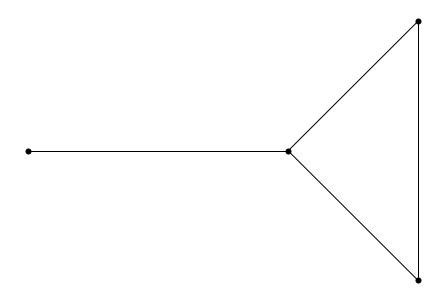

In [10]:
plot_graph(graph)

In [11]:
final_graph = iterate_graph(graph, rule, 500)

100%|██████████| 500/500 [00:05<00:00, 86.11it/s] 


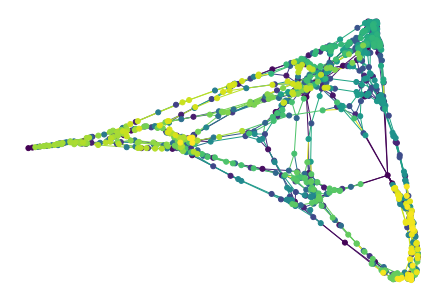

In [12]:
plot_graph(final_graph, color=True)